Dataset: https://www.kaggle.com/datasets/kshitijdhama/printed-digits-dataset/data

In [47]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

In [48]:
def bgr2rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

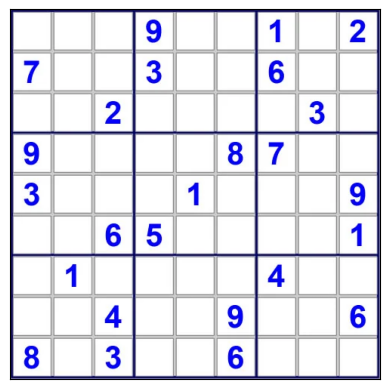

In [49]:
# FILE_PATH = './dummy_input/sudoku grid 2.jpg'
# FILE_PATH = './dummy_input/sudoku_grid_ex3.jpg'
# FILE_PATH = './dummy_input/wacky grid 3.png'
# FILE_PATH = './dummy_input/wacky grid 2.jpg'
# FILE_PATH = './dummy_input/sudoku_grid_ex4_color.jpg'
# FILE_PATH = './dummy_input/Screenshot 2024-12-04 202442.png'
FILE_PATH = './dummy_input/cpdfivsh9cv81.webp'
# FILE_PATH = './dummy_input/sudoku_grid_ex5_color.jpg'
image = cv2.imread(FILE_PATH)
plt.imshow(bgr2rgb(image))
plt.xticks([])
plt.yticks([])
plt.show() 

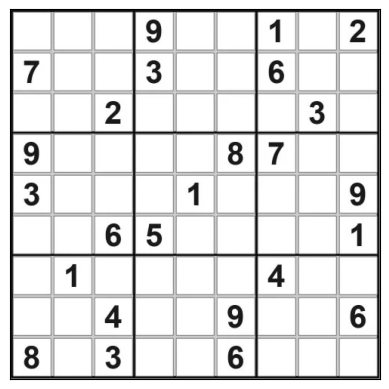

In [50]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

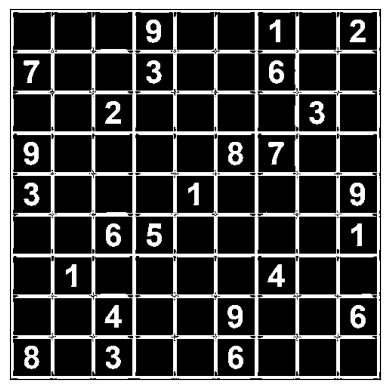

In [51]:
blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 7)
plt.imshow(thresh_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

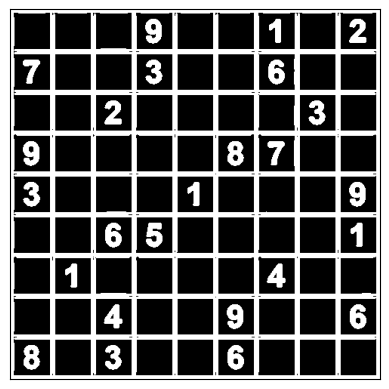

In [52]:
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

dilated_image = cv2.dilate(thresh_image, kernel, iterations=1)

# Display the dilated image
plt.imshow(dilated_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

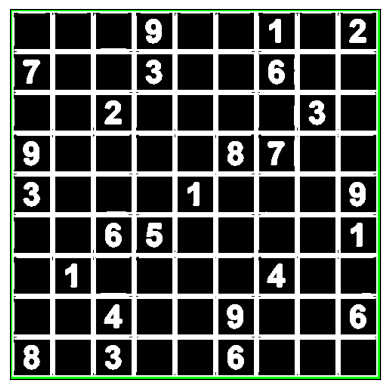

In [53]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
largest_contour = max(contours, key=cv2.contourArea)

contour_image = cv2.cvtColor(dilated_image, cv2.COLOR_GRAY2BGR)  
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)  

plt.imshow(contour_image)
plt.xticks([])
plt.yticks([])
plt.show()

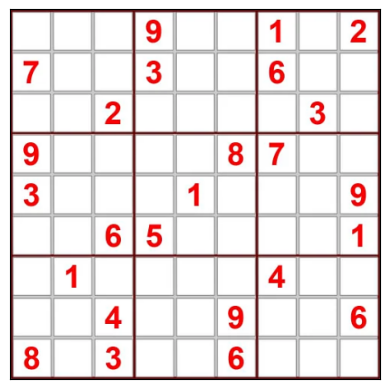

In [54]:
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

pts = approx.reshape(4, 2)

rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]  # Top-left
rect[2] = pts[np.argmax(s)]  # Bottom-right
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]  # Top-right
rect[3] = pts[np.argmax(diff)]  # Bottom-left

width = 450  
height = 450  
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

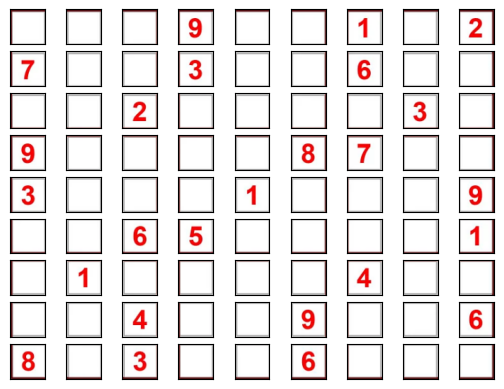

In [55]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(warped_image)

for i in range(len(boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(boxes[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

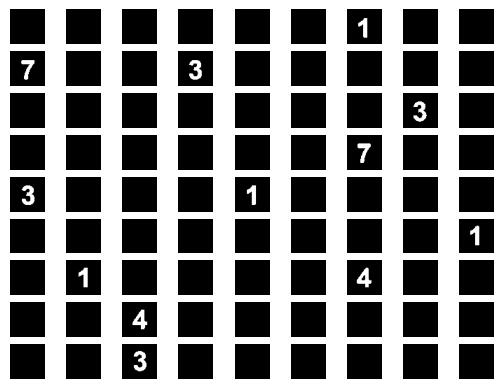

In [56]:
# Define parameters for filtering
MIN_SIZE = 20    # Minimum size of a component to consider it valid (adjust as needed)
MAX_SIZE = 300   # Maximum size to filter out noise (adjust as needed)
EDGE_THRESHOLD = 2  # Minimum distance from edges to consider a component (adjust as needed)
w, h = 50, 50

# Prepare a list to hold the processed images
processed_boxes = []

for i in range(len(boxes)):
    target_image = boxes[i]

    # Convert the image to grayscale
    gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    gray_target = cv2.resize(gray_target, (w, h))

    # Step 1: Threshold the image to create a binary image
    _, binary_image = cv2.threshold(gray_target, 180, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Find connected components
    num_labels, labels_im = cv2.connectedComponents(binary_image)

    # Step 3: Initialize variables to find the best component
    best_component = None  # Initialize as None
    best_size = 0
    height, width = gray_target.shape
    center_y, center_x = height // 2, width // 2  # Calculate the center of the image

    # Step 4: Loop through each component
    for label in range(1, num_labels):  # Start from 1 to skip the background
        component_mask = (labels_im == label).astype(np.uint8)  # Create a mask for the component
        size = np.sum(component_mask)  # Count the number of pixels in the component

        # Calculate the bounding box of the component
        y_indices, x_indices = np.where(component_mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip if there are no pixels in the component

        # Get the bounding box coordinates
        min_y, max_y = np.min(y_indices), np.max(y_indices)
        min_x, max_x = np.min(x_indices), np.max(x_indices)

        # Check if the component meets size and edge proximity criteria
        if (MIN_SIZE <= size <= MAX_SIZE and
            min_y > EDGE_THRESHOLD and max_y < height - EDGE_THRESHOLD and
            min_x > EDGE_THRESHOLD and max_x < width - EDGE_THRESHOLD):
            
            # Check if this is the best component found based on size
            if size > best_size:
                best_size = size
                best_component = component_mask  # Assign the mask to best_component

    # Step 5: Create a mask for the best component
    if best_component is not None:  # Check if a component was found
        mask = best_component.astype(np.uint8) * 255  # Convert to uint8 for masking

        # Step 6: Use the mask to create an output image where the digit is white and the background is black
        output_image = np.zeros_like(gray_target)  # Create a black image
        output_image[mask > 0] = 255  # Set the pixels of the digit to white

        processed_boxes.append(output_image)  # Store the processed image
    else:
        # If no component was found, append a completely black image
        processed_boxes.append(np.zeros_like(gray_target))  # All black image for no digit box

# Display the processed images
for i in range(len(processed_boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(processed_boxes[i], cmap='gray')  # Display processed images
    plt.axis('off')

plt.show()


In [ ]:
# model = tensorflow.keras.models.load_model('./Model/num_classifier_COMBINED.h5')
# model = tensorflow.keras.models.load_model('./num_classifier_printedImage.h5')

ValueError: File format not supported: filepath=./num_classifier_COMBINED_BALANCE_1500.tflite. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./num_classifier_COMBINED_BALANCE_1500.tflite, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

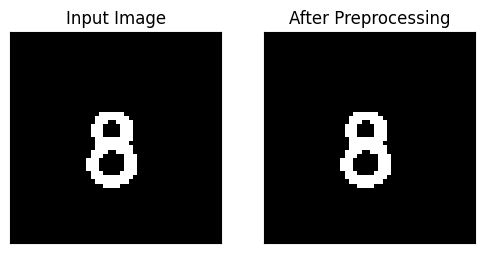

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Prediction: [8]


In [ ]:
def image_preprocessing_input(image): 
    image = cv2.resize(image, (w, h))
    image = cv2.equalizeHist(image)
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.reshape(w, h, 1)
    binary_image = binary_image / 255.0
    return binary_image

test_image = processed_boxes[53]
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(test_image, cmap='gray')
plt.xticks([])
plt.yticks([])

test_image_preprocessed = image_preprocessing_input(test_image)
test_image_preprocessed.shape
plt.subplot(1, 2, 2)
plt.title('After Preprocessing')
plt.imshow(test_image_preprocessed.reshape(w, h), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

test_image_preprocessed = np.expand_dims(test_image_preprocessed, axis=0)

y_pred = model.predict(test_image_preprocessed)
y_pred_labels = [np.argmax(i) for i in y_pred] 
print(f'Prediction: {y_pred_labels}')

In [ ]:
def image_preprocessing_input(image): 
    image = cv2.resize(image, (w, h))
    image = cv2.equalizeHist(image)
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.reshape(w, h, 1)
    binary_image = binary_image / 255.0
    return binary_image

sudoku_matrix = np.zeros((9, 9), dtype=int)

for i in range(9):
    for j in range(9):
        index = i * 9 + j  
        if index < len(processed_boxes):
            if np.sum(processed_boxes[index]) > 0:  
                test_image = processed_boxes[index]
                test_image_preprocessed = image_preprocessing_input(test_image)
                test_image_preprocessed = np.expand_dims(test_image_preprocessed, axis=0)
                
                y_pred = model.predict(test_image_preprocessed)
                y_pred_labels = np.argmax(y_pred)  
                sudoku_matrix[i, j] = y_pred_labels  
            else:
                sudoku_matrix[i, j] = 0  

print("Sudoku Matrix:")
print(sudoku_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

No solution exists
Answer Matrix:
[[0 0 0 5 2 0 8 0 9]
 [0 0 6 9 8 1 0 0 7]
 [1 0 9 3 0 0 0 5 6]
 [0 7 8 6 0 5 4 0 0]
 [0 0 0 0 0 8 9 0 1]
 [3 1 4 0 7 9 0 6 8]
 [6 4 1 0 0 0 7 9 3]
 [0 0 0 1 9 2 0 0 4]
 [0 9 2 0 6 4 1 3 5]]


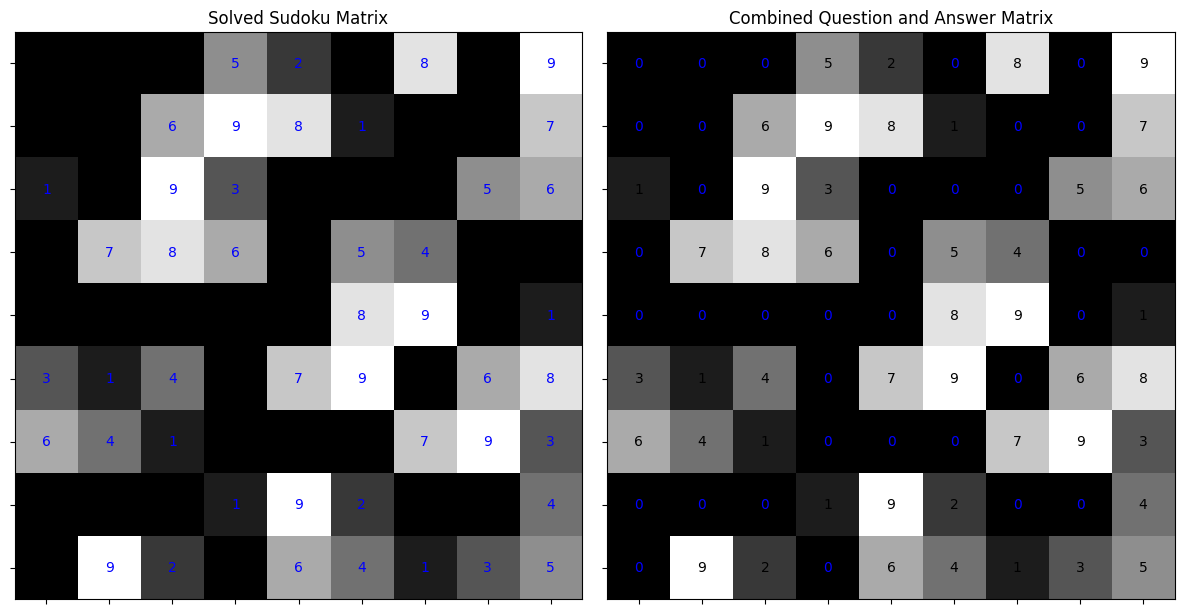

In [ ]:
# Define a function to check if a number can be placed in the Sudoku grid
def is_valid_move(matrix, row, col, num):
    # Check row
    if num in matrix[row]:
        return False
    # Check column
    if num in matrix[:, col]:
        return False
    # Check 3x3 grid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in matrix[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

# Backtracking function to solve the Sudoku puzzle
def solve_sudoku(matrix):
    for row in range(9):
        for col in range(9):
            if matrix[row, col] == 0:  # Empty cell found
                for num in range(1, 10):  # Numbers 1 to 9
                    if is_valid_move(matrix, row, col, num):
                        matrix[row, col] = num  # Place the number
                        if solve_sudoku(matrix):  # Recursive call
                            return True
                        matrix[row, col] = 0  # Backtrack
                return False  # No valid number found, backtrack
    return True  # Puzzle solved


# Copy the original matrix for displaying later
original_matrix = sudoku_matrix.copy()

# Solve the Sudoku
if solve_sudoku(sudoku_matrix):
    print("Sudoku Solved:")
else:
    print("No solution exists")

# Display the answer matrix
print("Answer Matrix:")
print(sudoku_matrix)

# Combine the question and answer matrices for display
combined_matrix = np.where(original_matrix != 0, original_matrix, sudoku_matrix)

# Display the answer and combined matrix
plt.figure(figsize=(12, 6))

# Display answer matrix
plt.subplot(1, 2, 1)
plt.title('Solved Sudoku Matrix')
plt.imshow(sudoku_matrix, cmap='gray', vmin=0, vmax=9)
plt.xticks(np.arange(9), [])
plt.yticks(np.arange(9), [])
for (i, j), val in np.ndenumerate(sudoku_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', color='blue' if val != 0 else 'black')

# Display combined matrix
plt.subplot(1, 2, 2)
plt.title('Combined Question and Answer Matrix')
plt.imshow(combined_matrix, cmap='gray', vmin=0, vmax=9)
plt.xticks(np.arange(9), [])
plt.yticks(np.arange(9), [])
for (i, j), val in np.ndenumerate(combined_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', color='blue' if original_matrix[i, j] == 0 else 'black')

plt.tight_layout()
plt.show()
